хочу быстро проверить 3 вещи:<br>
- есть ли пересечение по id для train / test
- какое у нас пересечение по времени для train / test
- для трейна: есть ли такое, что после того как прошла фродовая транзакция - все остальные тоже фродовые

In [59]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import sklearn
import sqlalchemy as sa
import multiprocessing
from collections import Counter
from dateutil import parser
import matplotlib.dates as mdates

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [39]:
import os
import re
import networkx as nx
from tqdm import tqdm, tqdm_notebook
import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
import matplotlib.dates as mdates
import dateutil

In [4]:
FIRST_N = 100
train_folder = '../../data/raw_splits/train/'
train_files = sorted([x for x in os.listdir(train_folder) if not '.pkl' in x], key = lambda x: int(re.sub('[^0-9]', '', x)))
train_files = [os.path.join(train_folder, x) for x in train_files]
print(f'Length of train files is {len(train_files)}')
train_files[:FIRST_N]

Length of train files is 51


['../../data/raw_splits/train/chunk_0.fth',
 '../../data/raw_splits/train/chunk_1.fth',
 '../../data/raw_splits/train/chunk_2.fth',
 '../../data/raw_splits/train/chunk_3.fth',
 '../../data/raw_splits/train/chunk_4.fth',
 '../../data/raw_splits/train/chunk_5.fth',
 '../../data/raw_splits/train/chunk_6.fth',
 '../../data/raw_splits/train/chunk_7.fth',
 '../../data/raw_splits/train/chunk_8.fth',
 '../../data/raw_splits/train/chunk_9.fth',
 '../../data/raw_splits/train/chunk_10.fth',
 '../../data/raw_splits/train/chunk_11.fth',
 '../../data/raw_splits/train/chunk_12.fth',
 '../../data/raw_splits/train/chunk_13.fth',
 '../../data/raw_splits/train/chunk_14.fth',
 '../../data/raw_splits/train/chunk_15.fth',
 '../../data/raw_splits/train/chunk_16.fth',
 '../../data/raw_splits/train/chunk_17.fth',
 '../../data/raw_splits/train/chunk_18.fth',
 '../../data/raw_splits/train/chunk_19.fth',
 '../../data/raw_splits/train/chunk_20.fth',
 '../../data/raw_splits/train/chunk_21.fth',
 '../../data/raw_spl

In [5]:
test_folder = '../../data/raw_splits/test/'
test_files = sorted([x for x in os.listdir(test_folder) if not '.pkl' in x], key = lambda x: int(re.sub('[^0-9]', '', x)))
test_files = [os.path.join(test_folder, x) for x in test_files]
print(f'Length of test files is {len(test_files)}')
test_files[:FIRST_N]

Length of test files is 26


['../../data/raw_splits/test/chunk_0.fth',
 '../../data/raw_splits/test/chunk_1.fth',
 '../../data/raw_splits/test/chunk_2.fth',
 '../../data/raw_splits/test/chunk_3.fth',
 '../../data/raw_splits/test/chunk_4.fth',
 '../../data/raw_splits/test/chunk_5.fth',
 '../../data/raw_splits/test/chunk_6.fth',
 '../../data/raw_splits/test/chunk_7.fth',
 '../../data/raw_splits/test/chunk_8.fth',
 '../../data/raw_splits/test/chunk_9.fth',
 '../../data/raw_splits/test/chunk_10.fth',
 '../../data/raw_splits/test/chunk_11.fth',
 '../../data/raw_splits/test/chunk_12.fth',
 '../../data/raw_splits/test/chunk_13.fth',
 '../../data/raw_splits/test/chunk_14.fth',
 '../../data/raw_splits/test/chunk_15.fth',
 '../../data/raw_splits/test/chunk_16.fth',
 '../../data/raw_splits/test/chunk_17.fth',
 '../../data/raw_splits/test/chunk_18.fth',
 '../../data/raw_splits/test/chunk_19.fth',
 '../../data/raw_splits/test/chunk_20.fth',
 '../../data/raw_splits/test/chunk_21.fth',
 '../../data/raw_splits/test/chunk_22.fth'

In [6]:
# функция получения lable из csutom_mark

def cust_mark_to_class(custom_mark):
    """
    Преобразует входящее значение CUSTOM_MARK в класс
    return:
        1 - фрод
        0 - легитимная
        -1 - неизвестно
    """
    ret = -1
    if custom_mark in ['F','S']:
        ret = 1
    elif custom_mark in ['A','G', 'null']:
        ret = 0
    
    return ret

---

In [7]:
def load_train(fname):
    chunk = pd.read_feather(fname)
    return chunk[['user_id', 'short_date', 'custom_mark']].copy()

def load_test(fname):
    chunk = pd.read_feather(fname)
    return chunk[['user_id', 'short_date']].copy()

In [8]:
%%time
with multiprocessing.Pool(processes=5) as pool:
    train_chunks = pool.map(load_train, train_files)

CPU times: user 24.3 s, sys: 13.9 s, total: 38.2 s
Wall time: 2min 32s


In [9]:
%%time
with multiprocessing.Pool(processes=5) as pool:
    test_chunks = pool.map(load_test, test_files)

CPU times: user 2.21 s, sys: 1.7 s, total: 3.91 s
Wall time: 24.7 s


In [10]:
gc.collect()

0

In [12]:
train = pd.concat(train_chunks)

In [33]:
test = pd.concat(test_chunks)

In [14]:
del train_chunks

In [34]:
del test_chunks

In [15]:
gc.collect()

0

In [19]:
Counter(train['custom_mark'])#.value_counts()

Counter({'A': 2,
         'F': 24069,
         'G': 122975,
         'S': 4606,
         'U': 16672,
         'null': 70237790})

ниже я проверил что совпадает с bd

In [20]:
# создание коннекта к БД и крурсора для запросов
conn = sqlite3.connect('../../data/input/hse_sqlite')
c = conn.cursor()

# создание engine для чтения данных в DataFrame
engine = sa.create_engine('sqlite:///../../data/input/hse_sqlite.db')

In [21]:
# пример получения перечня таблиц (в данном случае она будет 1)
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print ('Перечень таблиц: {0}\r\n\r\n'.format(c.fetchall()))

# перечень столбцов
c.execute("SELECT * FROM rsa_event_log LIMIT 1;")
cols = [descr[0] for descr in c.description]
print ('Столбцы в таблице: {0}'.format(cols))

Перечень таблиц: [('rsa_event_log',)]


Столбцы в таблице: ['cdf_s_123', 'cdf_s_124', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130', 'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126', 'cdf_s_133', 'cdf_s_136', 'cdf_s_137', 'cdf_s_140', 'cdf_s_178_hashed', 'cdf_s_19', 'cdf_s_20', 'cdf_s_218', 'cdf_s_294', 'cdf_s_299', 'amount_original', 'channel_indicator_desc', 'custom_mark', 'data_i_118', 'data_i_119', 'data_i_120', 'data_i_154', 'data_s_65', 'event_description', 'event_id', 'event_time', 'ext_acct_number_hashed', 'hardwareid', 'short_date', 'user_acct_number_hashed', 'user_agent_string_hash', 'browser_plugins_hash', 'screen_hash', 'user_id', 'ip_address', 'ip_country', 'ip_region', 'ip_city', 'ip_isp']


In [22]:
t = c.execute("SELECT * FROM rsa_event_log where custom_mark in ('F','S')")

In [24]:
t2 = c.fetchall()

In [30]:
cols[22]

'custom_mark'

In [31]:
Counter([x[22] for x in t2])

Counter({'F': 24069, 'S': 4606})

In [26]:
len(t2)

28675

теперь посмотрим на пересечение id

In [35]:
train_id = set(train['user_id'])
test_id = set(test['user_id'])

In [36]:
len(train_id), len(test_id), len(train_id & test_id)

(194704, 85764, 1341)

теперь посмотрим на временные интервалы

In [37]:
train.head(5)

,user_id,short_date,custom_mark
0,100197,20170825,null
1,100197,20171128,null
2,100197,20170507,null
3,100197,20170728,null
4,100197,20170913,null


In [70]:
train_sd = pd.Series(train['short_date']).value_counts().reset_index().rename(columns = {'index': 'short_date', 'short_date': 'freq'}).sort_values('short_date')
test_sd = pd.Series(test['short_date']).value_counts().reset_index().rename(columns = {'index': 'short_date', 'short_date': 'freq'}).sort_values('short_date')

In [108]:
train_fraud_sd = pd.Series(train.loc[train['custom_mark'].isin(['F', 'S']), 'short_date']).value_counts().reset_index().rename(columns = {'index': 'short_date', 'short_date': 'freq'}).sort_values('short_date')

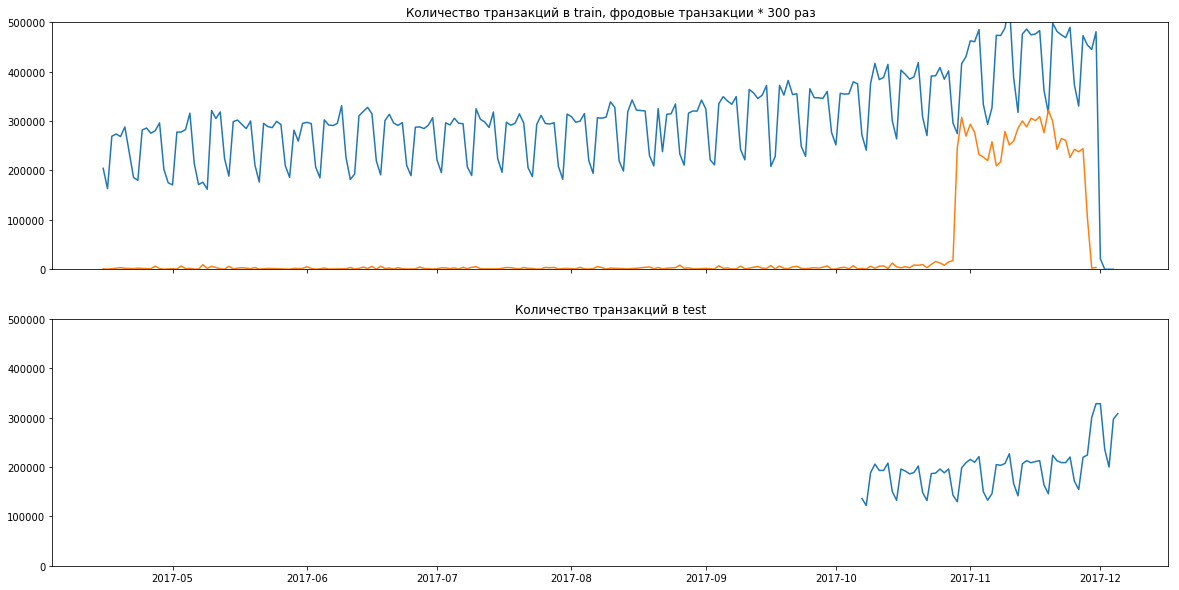

In [112]:
train_dates = [parser.parse(f'{x[6:]}/{x[4:6]}/{x[:4]}', dayfirst = True) for x in train_sd['short_date'].astype(str)]
train_fraud_dates = [parser.parse(f'{x[6:]}/{x[4:6]}/{x[:4]}', dayfirst = True) for x in train_fraud_sd['short_date'].astype(str)]
test_dates = [parser.parse(f'{x[6:]}/{x[4:6]}/{x[:4]}', dayfirst = True) for x in test_sd['short_date'].astype(str)]

fi, ax = plt.subplots(2, 1, sharex = True, figsize = (20, 10))

ax[0].format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax[0].plot(train_dates, train_sd['freq'])
ax[0].plot(train_fraud_dates, train_fraud_sd['freq'] * 300)
ax[0].set_title('Количество транзакций в train, фродовые транзакции * 300 раз')
ax[0].set_ylim([0, 500000])
ax[1].format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax[1].plot(test_dates, test_sd['freq'])
ax[1].set_title('Количество транзакций в test')
ax[1].set_ylim([0, 500000])
fig.autofmt_xdate()
plt.show()

посмотрим на то, есть ли в данном датасете люди, которые транзачили в начале 2017 и перестали транзачить после октября 17

In [115]:
not_dead = set(train.query('short_date >= 20171001')['user_id'])

In [118]:
train.query('short_date >= 20171001').shape

(24194812, 3)

In [119]:
train.shape

(70406114, 3)

In [116]:
len(not_dead)

194702

In [117]:
len(train_id)

194704

как видно, таких людей нет

In [120]:
train['is_fraud'] = [cust_mark_to_class(x) for x in train['custom_mark']]

In [123]:
fraud_users_ids = set(train.query('is_fraud == 1')['user_id'])

In [127]:
len(fraud_users_ids)

8477

In [131]:
temp = [True if x in bfraud_users_ids else False for x in tqdm_notebook(train['user_id'])]

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/alex/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/alex/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/alex/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [132]:
%%time
fraud_users = train.loc[temp]

CPU times: user 3.78 s, sys: 358 ms, total: 4.14 s
Wall time: 4.12 s


In [133]:
fraud_users.shape

(2341295, 4)

In [134]:
fraud_users.head(5)

,user_id,short_date,custom_mark,is_fraud
3102,10138697,20170417,null,0
3103,10138697,20170423,null,0
3104,10138697,20170714,null,0
3105,10138697,20170518,null,0
3106,10138697,20170525,null,0


In [139]:
print(f'Для нефродовых пользователей в среднем {(train.shape[0] - fraud_users.shape[0]) / (len(train_id) - len(fraud_users_ids))} транзакций')
print(f'Для фродовых пользователей в среднем {fraud_users.shape[0] / len(fraud_users_ids)} транзакций')

Для нефродовых пользователей в среднем 365.49382742566866 транзакций
Для фродовых пользователей в среднем 276.1938185678896 транзакций


In [141]:
rng = np.random.RandomState(1)
fraud_ids_sample = rng.choice(sorted(fraud_users_ids), size = 100)

In [153]:
fraud_users = fraud_users.sort_values('short_date')

In [163]:
plot_xs, plot_cs = [], []
for uid in tqdm_notebook(fraud_ids_sample):
    fraud_one_user = fraud_users.loc[(fraud_users['user_id'] == uid) & fraud_users['is_fraud'].isin([0, 1])]
    fraud_user_x = np.linspace(0, 1, num = fraud_one_user.shape[0])
    fraud_user_cumsum = np.cumsum(fraud_one_user['is_fraud'])
    fraud_user_cumsum /= np.max(fraud_user_cumsum)
    plot_xs.append(fraud_user_x)
    plot_cs.append(fraud_user_cumsum)

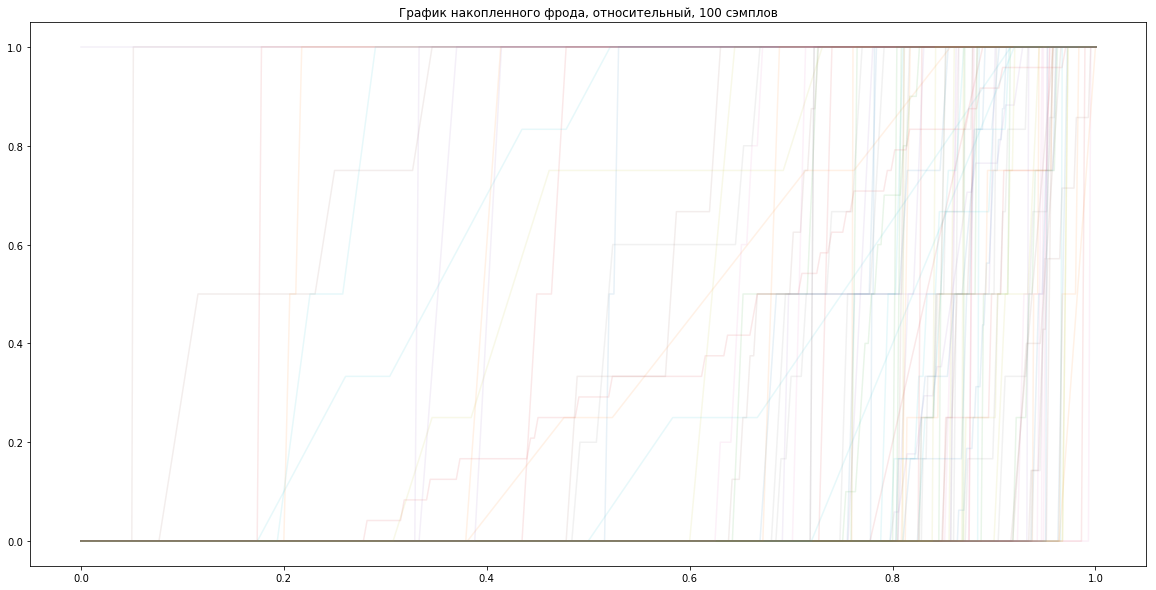

In [165]:
plt.figure(figsize = (20, 10))
plt.title('График накопленного фрода, относительный, 100 сэмплов')
for x, cs in zip(plot_xs, plot_cs):
    plt.plot(x, cs, alpha = 0.1)
plt.show()